In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import pickle
import json

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mutual_info_score, roc_auc_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("cleaned_no_emojis.csv")

df.head()

,active_weeks,target_variable,total_volume,trader_activity_status,trader_volume_status,trader_weekly_frequency_status,tx_count_365d,wallet
0,1,Bad Trader,38.726119,Regular User,Low Value Trader,Unserious,2,0xa3c6acd45396110466fd8972875b3e6d33a0b0b8
1,1,Bad Trader,135.943754,Occasional User,Middle Value Trader,Unserious,1,0xbc0452c93e33b886d0e6750a9fc261e1d3c877ed
2,1,Bad Trader,0.457897,Occasional User,Low Value Trader,Unserious,1,0x477b0f0e29494a1e108a302ffecff3d76663386c
3,5,Bad Trader,37.614307,Regular User,Low Value Trader,OG,8,0x02170d140c843646d4802f6e65f9236baccc2f70
4,1,Bad Trader,2.389608,Occasional User,Low Value Trader,Unserious,1,0xcb69aceac5956af777d4d77c8d01c1fdea5828bd


In [3]:
df['target_variable'] = df['target_variable'].replace({
    'Good Trader': 1,
    'Bad Trader': 0
})


/tmp/ipykernel_58823/3916386862.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['target_variable'] = df['target_variable'].replace({


In [4]:
df.head()

,active_weeks,target_variable,total_volume,trader_activity_status,trader_volume_status,trader_weekly_frequency_status,tx_count_365d,wallet
0,1,0,38.726119,Regular User,Low Value Trader,Unserious,2,0xa3c6acd45396110466fd8972875b3e6d33a0b0b8
1,1,0,135.943754,Occasional User,Middle Value Trader,Unserious,1,0xbc0452c93e33b886d0e6750a9fc261e1d3c877ed
2,1,0,0.457897,Occasional User,Low Value Trader,Unserious,1,0x477b0f0e29494a1e108a302ffecff3d76663386c
3,5,0,37.614307,Regular User,Low Value Trader,OG,8,0x02170d140c843646d4802f6e65f9236baccc2f70
4,1,0,2.389608,Occasional User,Low Value Trader,Unserious,1,0xcb69aceac5956af777d4d77c8d01c1fdea5828bd


In [5]:
print(df.shape)
print()
print(df.columns)
print()
print(df.dtypes)

(2000, 8)

Index(['active_weeks', 'target_variable', 'total_volume',
       'trader_activity_status', 'trader_volume_status',
       'trader_weekly_frequency_status', 'tx_count_365d', 'wallet'],
      dtype='object')

active_weeks                        int64
target_variable                     int64
total_volume                      float64
trader_activity_status             object
trader_volume_status               object
trader_weekly_frequency_status     object
tx_count_365d                       int64
wallet                             object
dtype: object


In [6]:

strings = list(df.dtypes[df.dtypes == 'object'].index)
strings

['trader_activity_status',
 'trader_volume_status',
 'trader_weekly_frequency_status',
 'wallet']

In [7]:
for col in strings:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [8]:
for col in df.columns:
    print(col)
    print(df[col].nunique())
    print(df[col].unique()[:5])
    print()

active_weeks
51
[1 5 3 2 8]

target_variable
2
[0 1]

total_volume
1948
[ 38.72611901 135.94375441   0.45789705  37.6143067    2.38960781]

trader_activity_status
3
['regular_user' 'occasional_user' 'frequent_user']

trader_volume_status
3
['low_value_trader' 'middle_value_trader' 'high_value_trader']

trader_weekly_frequency_status
3
['unserious' 'og' 'just_there']

tx_count_365d
224
[2 1 8 3 9]

wallet
2000
['0xa3c6acd45396110466fd8972875b3e6d33a0b0b8'
 '0xbc0452c93e33b886d0e6750a9fc261e1d3c877ed'
 '0x477b0f0e29494a1e108a302ffecff3d76663386c'
 '0x02170d140c843646d4802f6e65f9236baccc2f70'
 '0xcb69aceac5956af777d4d77c8d01c1fdea5828bd']



In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)


(1200, 400, 400)

In [10]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_train = df_train.target_variable.values
y_val = df_val.target_variable.values
y_test = df_test.target_variable.values

del df_train['target_variable']
del df_val['target_variable']
del df_test['target_variable']

In [11]:
df_full_train = df_full_train.reset_index(drop=True)

In [12]:

df_full_train.target_variable.value_counts(normalize=True)

target_variable
0    0.501875
1    0.498125
Name: proportion, dtype: float64

In [13]:
df_full_train.target_variable.mean()

np.float64(0.498125)

In [14]:
categorical = ["trader_activity_status", "trader_volume_status", "trader_weekly_frequency_status"]

numerical = ["active_weeks", "total_volume", "tx_count_365d"]

In [15]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.target_variable)

In [16]:
mi = df_full_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

trader_weekly_frequency_status    0.366017
trader_volume_status              0.358240
trader_activity_status            0.317445
dtype: float64

In [17]:
df_full_train[numerical].corrwith(df_full_train.target_variable).abs()

active_weeks     0.538168
total_volume     0.060747
tx_count_365d    0.049071
dtype: float64

In [18]:
dv = DictVectorizer(sparse= False)

In [19]:
pipeline = make_pipeline(
    dv,
    LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
)

In [20]:
train_dict = df_train[categorical + numerical].to_dict(orient= "records")

pipeline.fit(train_dict, y_train)

,steps,"[('dictvectorizer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True
,penalty,'l2'
,dual,False
,tol,0.0001


In [21]:
X_train = dv.fit_transform(train_dict)

In [22]:
val_dict = df_val[categorical + numerical].to_dict(orient= "records")
X_val = dv.transform(val_dict)

In [23]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [24]:
y_predict = model.predict_proba(X_val)[:, 1]

convert = (y_predict >= 0.5)

(y_val == convert).mean()

np.float64(0.5125)

In [25]:
full_train_dict = df_full_train[categorical + numerical].to_dict(orient= "records")
dv = DictVectorizer(sparse= False)
X_full_train = dv.fit_transform(full_train_dict)

y_full_train = df_full_train.target_variable.values

model_2 = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model_2.fit(X_full_train, y_full_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [26]:
test_dict = df_test[categorical + numerical].to_dict(orient= "records")

X_test = dv.transform(test_dict)

y_predictions = model_2.predict_proba(X_test)[:, 1]

decision = (y_predictions >= 0.5)

(decision == y_test).mean()

np.float64(0.5075)

In [27]:
y_pred = model.predict_proba(X_val)[:, 1]

round(roc_auc_score(y_val, y_pred), 3)

0.924

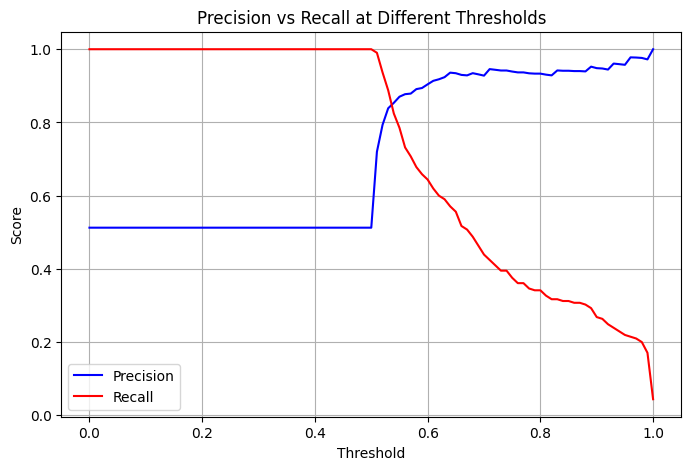

Precision and recall intersect at threshold ≈ 0.540


In [28]:
# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Define thresholds
thresholds = np.arange(0.0, 1.01, 0.01)

precisions = []
recalls = []

# Compute precision and recall for each threshold
for t in thresholds:
    preds = (y_pred_proba >= t).astype(int)
    precisions.append(precision_score(y_val, preds, zero_division= 0))
    recalls.append(recall_score(y_val, preds, zero_division= 0))

# Plot precision and recall curves
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

# Find intersection threshold (closest point where precision ≈ recall)
diff = np.abs(np.array(precisions) - np.array(recalls))
intersect_idx = np.argmin(diff)
intersect_threshold = thresholds[intersect_idx]

print(f"Precision and recall intersect at threshold ≈ {intersect_threshold:.3f}")

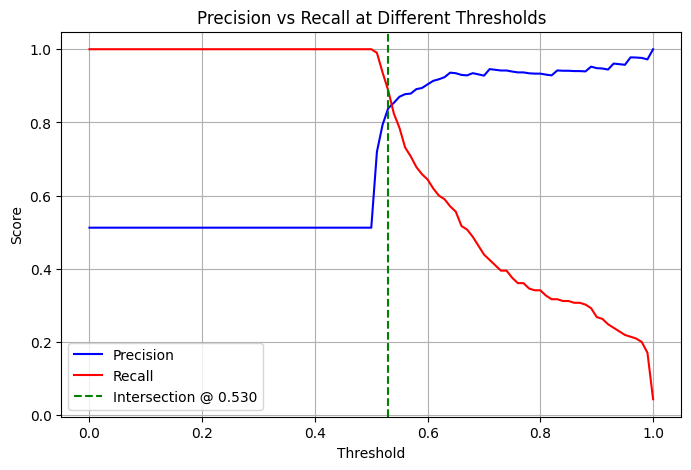

First meaningful intersection at threshold ≈ 0.530


In [29]:

# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Define thresholds
thresholds = np.arange(0.0, 1.01, 0.01)

precisions, recalls = [], []

# Compute precision and recall for each threshold
for t in thresholds:
    preds = (y_pred_proba >= t).astype(int)
    precisions.append(precision_score(y_val, preds, zero_division= 0))
    recalls.append(recall_score(y_val, preds, zero_division= 0))

precisions = np.array(precisions)
recalls = np.array(recalls)

# Find all intersections (where sign of precision - recall changes)
diff = precisions - recalls
cross_idxs = np.where(np.sign(diff[:-1]) * np.sign(diff[1:]) <= 0)[0]

if len(cross_idxs) > 0:
    # Take the first crossing as the "meaningful" one
    first_cross = cross_idxs[0]
    intersect_threshold = thresholds[first_cross]
else:
    intersect_threshold = None

# Plot precision and recall
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='red')
if intersect_threshold is not None:
    plt.axvline(intersect_threshold, color='green', linestyle='--', label=f'Intersection @ {intersect_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

if intersect_threshold is not None:
    print(f"First meaningful intersection at threshold ≈ {intersect_threshold:.3f}")
else:
    print("No intersection found within threshold range.")

In [30]:
# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Define thresholds
thresholds = np.arange(0.0, 1.01, 0.01)

precisions, recalls, f1_scores = [], [], []

# Compute precision, recall, and F1 for each threshold
for t in thresholds:
    preds = (y_pred_proba >= t).astype(int)
    P = precision_score(y_val, preds, zero_division= 0)
    R = recall_score(y_val, preds, zero_division= 0)
    if (P + R) == 0:
        f1 = 0
    else:
        f1 = 2 * P * R / (P + R)
    precisions.append(P)
    recalls.append(R)
    f1_scores.append(f1)

# Find the threshold with the maximum F1 score
max_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_idx]
best_f1 = f1_scores[max_f1_idx]

print(f"Maximum F1 score = {best_f1:.3f} at threshold ≈ {best_threshold:.3f}")

Maximum F1 score = 0.863 at threshold ≈ 0.530


In [37]:
# Prepare KFold
n_splits = 5
kfold = KFold(n_splits= 5, shuffle=True, random_state=1)

# Store AUC results
scores = []

# Loop over folds
for train_idx, val_idx in tqdm(kfold.split(df_full_train), total = n_splits):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    # ✅ Corrected assignments
    y_train = df_train.target_variable.values
    y_val = df_val.target_variable.values
    
    # Convert categorical & numerical features to dicts for DictVectorizer
    train_dict = df_train[categorical + numerical].to_dict(orient="records")
    val_dict = df_val[categorical + numerical].to_dict(orient="records")
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)
    
    # Train logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Evaluate AUC on validation set
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
    print(f"AUC on fold: {auc:.3f}")

# Compute mean and std of AUCs
mean_auc = np.mean(scores)
std_auc = np.std(scores)

print("\nCross-validation results")
print(f"Mean AUC: {mean_auc:.3f}")
print(f"Std AUC:  {std_auc:.4f}")

100%|██████████| 5/5 [00:00<00:00, 62.26it/s]

AUC on fold: 0.923
AUC on fold: 0.894
AUC on fold: 0.949
AUC on fold: 0.921
AUC on fold: 0.949

Cross-validation results
Mean AUC: 0.927
Std AUC:  0.0205


In [32]:
# Prepare
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
C_values = [0.000001, 0.001, 1]
results = []

for C in tqdm(C_values, desc="Hyperparameter tuning"):
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.target_variable.values
        y_val = df_val.target_variable.values
        
        train_dict = df_train[categorical + numerical].to_dict(orient="records")
        val_dict = df_val[categorical + numerical].to_dict(orient="records")
        
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    mean_auc = round(np.mean(scores), 3)
    std_auc = round(np.std(scores), 3)
    results.append((C, mean_auc, std_auc))
    print(f"C={C} -> Mean AUC: {mean_auc:.3f}, Std: {std_auc:.3f}")

# Display results
print("\nCross-validation summary:")
for r in results:
    print(f"C={r[0]}: Mean AUC={r[1]}, Std={r[2]}")

# Select best C
results_sorted = sorted(results, key=lambda x: (-x[1], x[2], x[0]))
best_C = results_sorted[0][0]
print(f"\nBest C = {best_C}")

Hyperparameter tuning: 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

C=1e-06 -> Mean AUC: 0.927, Std: 0.014
C=0.001 -> Mean AUC: 0.927, Std: 0.021
C=1 -> Mean AUC: 0.927, Std: 0.021

Cross-validation summary:
C=1e-06: Mean AUC=0.927, Std=0.014
C=0.001: Mean AUC=0.927, Std=0.021
C=1: Mean AUC=0.927, Std=0.021

Best C = 1e-06


In [54]:
with open ("model.bin", "wb") as file_out:
    pickle.dump(pipeline, file_out)

In [55]:
with open ("model.bin", "rb") as file_in:
    pipeline = pickle.load(file_in)

In [51]:
# Load your dataset
df = pd.read_csv("cleaned_no_emojis.csv")


# Pick one random row
random_row = df.sample(n=1, random_state=None)

# Convert it to a dictionary (column: value)
row_dict = random_row.iloc[0].to_dict()

print(json.dumps(row_dict, indent=2))


{
  "active_weeks": 1,
  "target_variable": "Bad Trader",
  "total_volume": 33.56155615237258,
  "trader_activity_status": "Occasional User",
  "trader_volume_status": "Low Value Trader",
  "trader_weekly_frequency_status": "Unserious",
  "tx_count_365d": 1,
  "wallet": "0x358616971380274a3f0e7d4bd51195310992bdd4"
}


In [57]:
customer = {
  "active_weeks": 1,
  "total_volume": 33.56155615237258,
  "trader_activity_status": "Occasional User",
  "trader_volume_status": "Low Value Trader",
  "trader_weekly_frequency_status": "Unserious",
  "tx_count_365d": 1,
  "wallet": "0x358616971380274a3f0e7d4bd51195310992bdd4"
}


target = pipeline.predict_proba(customer)[0, 1]

target

np.float64(0.5038253245663656)